# Heurísticas Construtivas aplicadas ao TSP

**Desenvolvedor**: Vítor Gabriel Reis Caitité 

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
import time 
from random import choice
import time

## Função para cálculo da matrix de distâncias

In [2]:
# Cálculo da matrix de distâncias considerando a distância euclideana
def calculate_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            d[l, c] = sqrt(sum((data[l] - data[c])**2))
    return d

# Cálculo da matrix de distâncias considerando a distância pseudo-euclideana
def calculate_pseudo_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            rij = sqrt(sum((data[l] - data[c])**2)/10.0)
            tij = round(rij)
            if tij < rij:
                dij = tij + 1
            else:
                dij = tij
            d[l, c] = dij
    return d

### Exemplo de matrix de distâncias para o problema kroa100

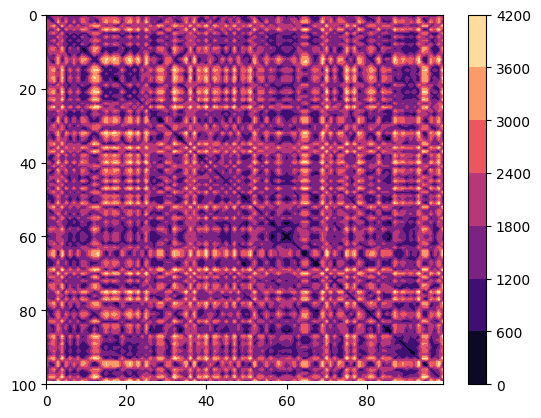

In [3]:
arquives_path = '~/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/instances/EUC_2D/'
df = pd.read_csv(f'{arquives_path}kroA100.tsp', skiprows=range(0, 6), sep='\s+',                       names=["X", "Y"], header=None) 
data = df.drop(df.tail(1).index, axis=0).to_numpy()
d = calculate_euc_distance_matrix(data)
plt.contourf(d, cmap='magma')
plt.ylim([data.shape[0], 0])
plt.colorbar()

## Nearest Neighbor

In [4]:
# Nearest neighbor for TSP:
def nearest_neighbor(distance_matrix, start):
    path = [start]  # variable to save the path
    cost = 0
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool) # to control which cities remain to visit   
    unvisited[start] = 0 
    for i in range(distance_matrix.shape[0]-1):
        last_city = path[-1]
        # finding the nearest neighbor for the last city:
        next_idx = np.argmin(distance_matrix[last_city][unvisited]) 
        next_city = np.arange(distance_matrix.shape[0])[unvisited][next_idx] 
        # adding the nearest neighbor to the path
        path.append(next_city)
        unvisited[next_city] = 0
        # Updating the cost
        cost += distance_matrix[last_city, next_city]
    # Updating the cost to add the cost from the lasst city to the first one.
    cost += distance_matrix[path[-1], path[0]]
    return path, cost

## Cheapest Insertion

In [5]:
# Cheapest neighbor for TSP:
def cheapest_insertion(distance_matrix, start):
    path = [start]   # variable to save the path
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)  # to control which cities remain to visit   
    unvisited[start] = 0 
    
    # Find the closest city to the first city:
    next_ind = np.argmin(distance_matrix[-1][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind]
    path.append(next_loc) # city 2
    unvisited[next_loc] = 0
    
    cost = distance_matrix[start, next_loc]
    new_path = []
    while len(path) < distance_matrix.shape[0]:
        # Find the closest neighbor to the tour (min cik + ckj - cij)
        smaller = np.inf
        for k in range(distance_matrix.shape[0]):
            if not unvisited[k]:
                continue
            # Finding the city which the cost of insert (dik + dkj − dij ) is the cheapest one.
            for i in range(len(path)-1):
                d = distance_matrix[path[i]][k] + distance_matrix[k][path[i+1]] - distance_matrix[path[i]][path[i+1]]
                if d < smaller:
                    smaller = d
                    new_path = path[:i + 1] + [k] + path[i + 1:]
                    new_city = k
        unvisited[new_city] = 0
        path = new_path
        # Updating the cost
        cost += smaller
    # Updating the cost to add the cost from the lasst city to the first one.
    cost += distance_matrix[path[-1], path[0]] 
    return path, cost

## Nearest Insertion

In [6]:
# Nearest insertion for TSP:
def nearest_insertion(distance_matrix, start):
    # Step 1. Start with a sub-graph consisting of node i only
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)   
    unvisited[start] = 0
    
    # Step 2. Find node r such that c_ir is minimal and form sub-tour i-r-i. 
    # initialize path with 2 first cities
    path = [start] # city 1
    next_ind = np.argmin(distance_matrix[path[-1]][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind] 
    path.append(next_loc) # city 2
    unvisited[next_loc] = 0
    
    while len(path) < distance_matrix.shape[0]:
        smaller = np.inf
        # Step 3. (Selection step) Given a sub-tour, find node r not 
        # in the sub-tour closest to any node j in the sub-tour; i.e. with minimal c_rj 
        for i in range(len(path)):                
            idx = np.argmin(distance_matrix[path[i]][unvisited])
            min_distance = distance_matrix[path[i]][unvisited][idx]
            if min_distance < smaller:
                smaller_idx = np.arange(distance_matrix.shape[0])[unvisited][idx]
                smaller = min_distance
        
        unvisited[smaller_idx] = 0 
        insertion_cost = np.inf
        path.append(path[0])
        # Step 4. (Insertion step) Find the arc (i, j) in the sub-tour
        # which minimizes c_ir + c_rj - c_ij . Insert r between i and j. 
        for i in range(len(path)-1):
            new_insertion_cost = distance_matrix[path[i], smaller_idx] + distance_matrix[path[i+1], smaller_idx] - distance_matrix[path[i], path[i+1]]  
            if new_insertion_cost < insertion_cost:
                insertion_cost = new_insertion_cost
                insertion_idx = i
        path.insert(insertion_idx+1, smaller_idx)
        path = path[:-1]
        #Step 5. If all the nodes are added to the tour, stop. Else go to step 3  
    # Calculating the cost
    cost = 0 
    for i in range(len(path)-1):
        cost += distance_matrix[path[i], path[i+1]]
    cost += distance_matrix[path[-1], path[0]] 
    return path, cost

## Farthest Insertion

Para esse algoritmo, durante a pesquisa 2 formulações diferentes foram encontradas:
  
  - 1) Esse algoritmo começa com uma cidade e a conecta com a cidade mais distante dela. Em seguida, ele encontra repetidamente a cidade que ainda não está na rota e que está mais  distante do caminho já visitado e a coloca entre as duas cidades que permitem que a rota resultante seja a mais curta possível.
  
  - 2) Esse algoritmo começa com uma cidade e a conecta com a cidade mais distante dela. Em seguida, ele encontra repetidamente a cidade que ainda não está na rota e que está mais  distante possível de uma cidade já visitada e a coloca entre as duas cidades que permitem que a rota resultante seja a mais curta possível.

In [7]:
# Farthest insertion for TSP:
def farthest_insertion1(distance_matrix, start):
    cost=0
    # Step 1. Start with a sub-graph consisting of node i only
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)   
    unvisited[start] = 0
    # Step 2. Find node r such that c_ir is maximal and form sub-tour i-r-i. 
    # initialize path with 2 first cities
    path = [start] # city 1
    next_ind = np.argmax(distance_matrix[path[-1]][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind] 
    path.append(next_loc) # city 2
    unvisited[next_loc] = 0
    while len(path) < distance_matrix.shape[0]:
        tour_distances = {}
        # Step 3. (Selection step) Given a sub-tour, find a
        # node not in the sub-tour farthest to the sub-tour;
        for i in range(distance_matrix.shape[0]):
            if not unvisited[i]:
                continue
            distances = []
            for j in range(len(path)):  
                distances.append(distance_matrix[path[j], i])
            tour_distances[i] = min(distances) 
        larger_idx = max(tour_distances, key=tour_distances.get)
        unvisited[larger_idx] = 0
        insertion_cost = np.inf
        path.append(path[0])
        # Step 4. (Insertion step) Find the arc (i, j) in the sub-tour
        # which minimizes c_ir + c_rj - c_ij . Insert r between i and j. 
        for i in range(len(path)-1):
            new_insertion_cost = distance_matrix[path[i], larger_idx] + distance_matrix[larger_idx, path[i+1]] - distance_matrix[path[i], path[i+1]]  
            if new_insertion_cost < insertion_cost:
                insertion_cost = new_insertion_cost
                insertion_idx = i
        path.insert(insertion_idx+1, larger_idx)
        path = path[:-1]
        #Step 5. If all the nodes are added to the tour, stop. Else go to step 3 
    # Calculating the cost
    path.append(path[0])
    for i in range(len(path)-1):
        cost += distance_matrix[path[i], path[i+1]]   
    return path, cost

In [8]:
# Farthest insertion for TSP:
def farthest_insertion2(distance_matrix, start):
    cost=0
    # Step 1. Start with a sub-graph consisting of node i only
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)   
    unvisited[start] = 0
    
    # Step 2. Find node r such that c_ir is maximal and form sub-tour i-r-i. 
    # initialize path with 2 first cities
    path = [start] # city 1
    next_ind = np.argmax(distance_matrix[path[-1]][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind] 
    path.append(next_loc) # city 2
    unvisited[next_loc] = 0
    while len(path) < distance_matrix.shape[0]:
        larger = 0
        # Step 3. (Selection step) Given a sub-tour, find node r not 
        # in the sub-tour farthest to a node j in the sub-tour; i.e. with maximal c_rj 
        for i in range(len(path)):                
            idx = np.argmax(distance_matrix[path[i]][unvisited])
            max_distance = distance_matrix[path[i]][unvisited][idx]
            if max_distance > larger:
                larger_idx = np.arange(distance_matrix.shape[0])[unvisited][idx]
                larger = max_distance
        
        unvisited[larger_idx] = 0
        insertion_cost = np.inf
        path.append(path[0])
        # Step 4. (Insertion step) Find the arc (i, j) in the sub-tour
        # which minimizes c_ir + c_rj - c_ij . Insert r between i and j. 
        for i in range(len(path)-1):
            new_insertion_cost = distance_matrix[path[i], larger_idx] + distance_matrix[larger_idx, path[i+1]] - distance_matrix[path[i], path[i+1]]  
            if new_insertion_cost < insertion_cost:
                insertion_cost = new_insertion_cost
                insertion_idx = i
        path.insert(insertion_idx+1, larger_idx)
        path = path[:-1]
        #Step 5. If all the nodes are added to the tour, stop. Else go to step 3 
    # Calculating the cost
    for i in range(len(path)-1):
        cost += distance_matrix[path[i], path[i+1]]
    cost += distance_matrix[path[-1], path[0]]    
    return path, cost

## Função para aplicação dos testes

In [17]:
def apply_test(arquives, n_tests):
    final_results = [["Arquivo", 'Nearest Neighbor', 'Cheapest Insertion', 'Nearest Insertion', 
                     "Farthest Insertion_1", "Farthest Insertion_2"]]
    final_time_results = [["Arquivo", 'Nearest Neighbor', 'Cheapest Insertion', 'Nearest Insertion', 
                     "Farthest Insertion_1", "Farthest Insertion_2"]]
    for arquive in arquives:
        df = pd.read_csv(f'{arquives_path}{arquive}', skiprows=range(0, 6), sep='\s+',                       names=["X", "Y"], header=None) 
        data = df.drop(df.tail(1).index, axis=0).to_numpy()
        if n_tests > data.shape[0]:
            n_tests = data.shape[0]
        if arquive == 'att48.tsp':
            distance_matrix = calculate_pseudo_euc_distance_matrix(data)
        else:
            distance_matrix = calculate_euc_distance_matrix(data)
        nn_results = np.zeros(n_tests) # for nearest neighbor
        ci_results = np.zeros(n_tests) # for cheapest insertion
        ni_results = np.zeros(n_tests) # for nearest insertion
        fi1_results = np.zeros(n_tests) # for farthest insertion
        fi2_results = np.zeros(n_tests) # for farthest insertion
        nn_time_results = np.zeros(n_tests) # for nearest neighbor
        ci_time_results = np.zeros(n_tests) # for cheapest insertion
        ni_time_results = np.zeros(n_tests) # for nearest insertion
        fi1_time_results = np.zeros(n_tests) # for farthest insertion
        fi2_time_results = np.zeros(n_tests) # for farthest insertion
        for idx in range(n_tests):
            to_test = np.ones(data.shape[0], dtype=bool)
            possible_starts = np.arange(0, data.shape[0])
            start = choice(possible_starts[to_test])
            to_test[start] = 0
            start_time = time.time()
            _, nn_results[idx] = nearest_neighbor(distance_matrix, start)
            end_time = time.time()
            nn_time_results[idx] = (end_time - start_time)*1000
            start_time = time.time()
            _, ci_results[idx] = cheapest_insertion(distance_matrix, start)
            end_time = time.time()
            ci_time_results[idx] = (end_time - start_time)*1000
            start_time = time.time()
            _, ni_results[idx] = nearest_insertion(distance_matrix, start)
            end_time = time.time()
            ni_time_results[idx] = (end_time - start_time)*1000
            start_time = time.time()
            _, fi1_results[idx] = farthest_insertion1(distance_matrix, start)
            end_time = time.time()
            fi1_time_results[idx] = (end_time - start_time)*1000
            start_time = time.time()
            _, fi2_results[idx] = farthest_insertion2(distance_matrix, start)
            end_time = time.time()
            fi2_time_results[idx] = (end_time - start_time)*1000
        result = [arquive,
                 '{:.0f}'.format(nn_results.mean()) + " +/- " + '{:.0f}'.format(nn_results.std()),
                 '{:.0f}'.format(ci_results.mean()) + " +/- " + '{:.0f}'.format(ci_results.std()),
                 '{:.0f}'.format(ni_results.mean()) + " +/- " + '{:.0f}'.format(ni_results.std()),
                 '{:.0f}'.format(fi1_results.mean()) + " +/- " + '{:.0f}'.format(fi1_results.std()),
                 '{:.0f}'.format(fi2_results.mean()) + " +/- " + '{:.0f}'.format(fi2_results.std())]
        
        time_result = [arquive,
                 '{:.1f}'.format(nn_time_results.mean()) + " +/- " + '{:.1f}'.format(nn_time_results.std()),
                 '{:.1f}'.format(ci_time_results.mean()) + " +/- " + '{:.1f}'.format(ci_time_results.std()),
                 '{:.1f}'.format(ni_time_results.mean()) + " +/- " + '{:.1f}'.format(ni_time_results.std()),
                 '{:.1f}'.format(fi1_time_results.mean()) + " +/- " + '{:.1f}'.format(fi1_time_results.std()),
                 '{:.1f}'.format(fi2_time_results.mean()) + " +/- " + '{:.1f}'.format(fi2_time_results.std())]    
        final_results.append(result)
        final_time_results.append(time_result)
    return final_results, final_time_results

## Resultados

In [18]:
import os
import re
import tabulate
arquives = []
for root, dirs, files in os.walk('/home/vitor/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/instances'):
    for filename in files:
        if re.search(r'.tsp', filename):
            arquives.append(filename)
results, time_results = apply_test(arquives, 10)
# Generating table results:
table1 = tabulate.tabulate(results, tablefmt='grid')
table2 = tabulate.tabulate(time_results, tablefmt='grid')

### Custo obtido por cada algoritmo em cada arquivo de teste.

In [19]:
print(table1)

+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| Arquivo      | Nearest Neighbor | Cheapest Insertion | Nearest Insertion | Farthest Insertion_1 | Farthest Insertion_2 |
+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| kroA150.tsp  | 33189 +/- 829    | 31677 +/- 432      | 31287 +/- 471     | 28418 +/- 528        | 30768 +/- 296        |
+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| kroB100.tsp  | 28275 +/- 883    | 26458 +/- 714      | 27092 +/- 188     | 23251 +/- 342        | 24652 +/- 301        |
+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| pr107.tsp    | 48879 +/- 1556   | 52596 +/- 1393     | 53115 +/- 681     | 45512 +/- 190        | 46756 +/- 1385       |
+--------------+

### Tempo de execução (ms) de cada algoritmo em cada arquivo de teste. Processador i7 7th Gen., 8 Gb de RAM, sistema Linux.

In [20]:
print(table2)

+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| Arquivo      | Nearest Neighbor | Cheapest Insertion | Nearest Insertion | Farthest Insertion_1 | Farthest Insertion_2 |
+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| kroA150.tsp  | 1.0 +/- 0.4      | 422.6 +/- 19.0     | 57.1 +/- 3.1      | 120.1 +/- 7.7        | 53.9 +/- 3.3         |
+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| kroB100.tsp  | 0.5 +/- 0.1      | 135.4 +/- 8.7      | 24.3 +/- 2.3      | 36.8 +/- 2.6         | 24.0 +/- 2.3         |
+--------------+------------------+--------------------+-------------------+----------------------+----------------------+
| pr107.tsp    | 0.7 +/- 0.1      | 179.5 +/- 25.5     | 29.3 +/- 3.7      | 52.6 +/- 6.8         | 29.8 +/- 4.0         |
+--------------+